In [1]:
#자기가 사용하는 gpu 할당
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=7

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=7


In [2]:
import torch

import torch.nn.functional as F

from loader import get_dataloader
from train import run
from models import PointNet, PointCNN

In [3]:
epochs=200
b_size=8
lr=0.001
lr_decay=0.5
lr_decay_step=50
weight_decay=0
num_class = 10 #
name = '{}'.format(num_class)
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')

train_loader, test_loader = get_dataloader(1024, b_size)
print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())
print(torch.cuda.get_device_name(device))

Available devices  1
Current cuda device  0
GeForce RTX 2080 Ti


In [ ]:
#Train
model = PointCNN(num_class)
run(train_loader, test_loader, model, epochs, b_size, lr,
    lr_decay, lr_decay_step, weight_decay, device)

In [5]:
#load pretrained
from train import test
PATH = "saves/"+model._get_name() +".pth"
model.load_state_dict(torch.load(PATH))
model.eval()

#test the loaded model
model = model.to(device)
test_acc = test(model,test_loader, device)
print ("test acc: {:.04f}".format(test_acc))

test acc: 0.9328


In [7]:
test_dataset = test_loader.dataset

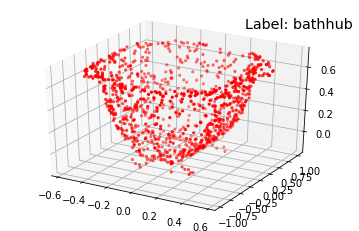

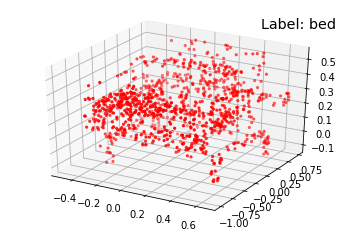

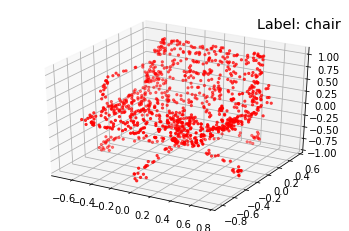

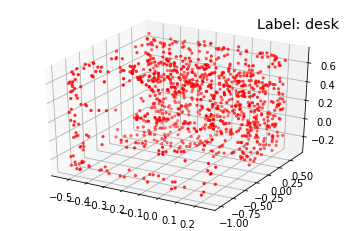

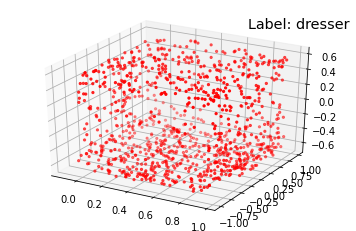

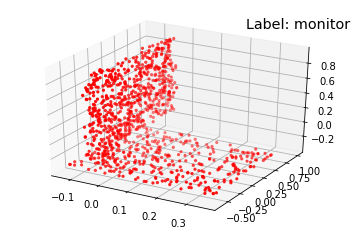

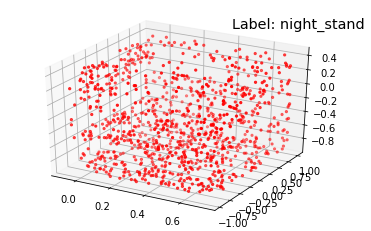

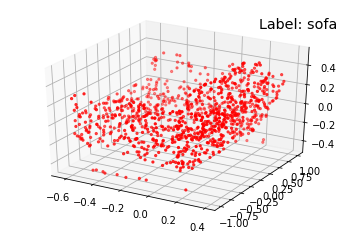

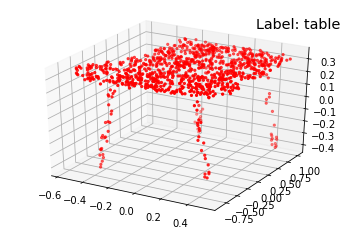

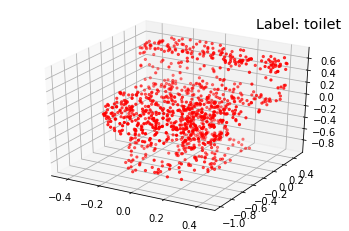

In [8]:
from utils import visualize

check=[]

for data in test_dataset:
    if data.y.item() not in check:
        pos = data.pos
        label = data.y.item()
        visualize(pos,label)
        check.append(data.y.item())

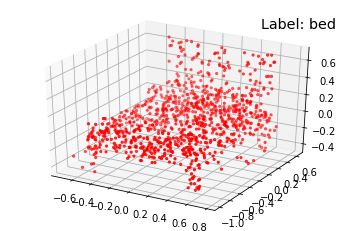

expected label : 1, answer label : 1


In [9]:
idx = 102
data=test_dataset[idx]
visualize(data.pos, data.y.item())
data=data.to(device)
pos = data.pos
score = model(pos, torch.zeros(1024, dtype=torch.long).to(device))
print("expected label : {}, answer label : {}".format(torch.argmax(score).item(), data.y.item()))


In [10]:
from attack import fgsm_attack
import torch.nn.functional as F

pos.requires_grad = True
score = model(pos, torch.zeros(1024, dtype=torch.long).to(device))
loss = F.nll_loss(score, torch.tensor([6],dtype=torch.long).cuda())
# Zero all existing gradients
model.zero_grad()
# Calculate gradients of model in backward pass
loss.backward()
# Collect datagrad
data_grad = pos.grad.data

epsilon=0.3
perturbed_pos = fgsm_attack(pos, epsilon, data_grad)

output = model(perturbed_pos, torch.zeros(1024, dtype=torch.long).to(device))

print(loss, output)

tensor(55.9761, device='cuda:0', grad_fn=<NllLossBackward>) tensor([[-1.1616e+01, -9.4277e-03, -4.7020e+00, -1.6176e+01, -1.6418e+01,
         -2.2064e+01, -8.3166e+00, -1.4640e+01, -1.0362e+01, -1.0778e+01]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward>)


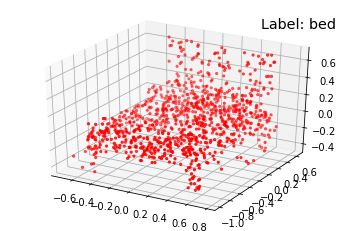

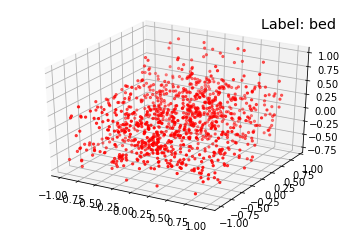

In [11]:
visualize(pos.cpu().detach(), data.y.item())
visualize(perturbed_pos.cpu().detach(), torch.argmax(output).item())